# Questions
- the text data file has 625 respondents; # data file has 583 -- need them to be downloaded at the same exact time to match

# Progress updates
    - 6/10 - cleaning up look of histograms/ finishing testing functionality, mapping text data
    - 6/16 - t-value calculations

# Notes
    - focus on getting histograms and t-tests for all the questions as they relate to the demographics so that we can get a sense of the data. Then get into linear regressions after that.

In [134]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
import pandas as pd
import math

In [179]:
matplotlib.rcParams['figure.figsize'] = [10, 8]

# Methods

In [108]:
#src: https://www.geeksforgeeks.org/counting-the-frequencies-in-a-list-using-dictionary-in-python/
def CountFrequency(my_list):
    # Creating an empty dictionary
    count = {}
    
    for i in my_list:
        count[i] = count.get(i, 0) + 1
    return count

In [69]:
def create_column_mapping(df, columns_text_list):
    ## returns: a dict with the keys = textual column labels
    ##     and values = raw data column labels 
    
    assert(type(df) == pd.core.frame.DataFrame)
    assert(type(columns_text_list) == list)
    
    raw_columns = pd.Index.tolist(df.columns)
    
    ## zip(keys, vals)
    return dict(zip(columns_text_list, raw_columns))
    
    

In [335]:
def clean_raw_data(df, elim_top_rows = 0, elim_every_other = False):
    ## returns: a dataframe containing only 
    ##      relevant rows from the raw data
    assert(type(df) == pd.core.frame.DataFrame)
    
    ## clean up extraneous top x rows
    data_temp = df.iloc[elim_top_rows:df.index.size]
    if elim_every_other == True:
        ## every other row in the raw data is blank. clean that up
        data_temp = data_temp.iloc[::2]
    return data_temp
    

In [307]:
def convert_data_types(df):
    ## df - dataframe
    ## NOTE: THIS OPERATES ON THE DATAFRAME IN PLACE
    for i in range(0,len(df.columns)):
        tempcol = df[df.columns[i]]
        testind = tempcol.index[0]
        
        try:
            float(tempcol[testind])
            df[df.columns[i]] = df[df.columns[i]].astype(float)
        except:
            #this doesnt seem to be working? (dont know if it matters) 
            df[df.columns[i]] = df[df.columns[i]].astype(str)    

In [458]:
def create_histogram(data, x_title, mapping, prob=True, include_non_answers=False, show_mean=False, 
                     show_resp_row_num=-1):
    ## data -- clean data dataframe 
    ## x_title -- string
    ## include_non_answers -- boolean; includes people that didnt respond to the Q in the hist
    ## prob -- boolean; if true, show %'s, if false, show frequency
    ## mapping -- the column mapping returned from create_column_mapping
    ## show_mean -- boolean, shows the average from the histogram
    ## show_resp_row_num -- integer [0-# responses-1], the row number of the respondent whose answer you want to display
    
    mean = -1
    t = mapping[x_title]
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
    
    labels, counts = np.unique(flat_list, return_counts=True)
    
    # in the main code we replaced the NaNs with 0's, 
    # so here, we just eliminate that info from our hist before making graph
    if include_non_answers == False:
        labels = labels[1:len(labels)]
        counts = counts[1:len(counts)]
        
    if prob == True:
        total = np.sum(counts)
        counts = [float(i) for i in counts]
        counts[:] = [x / total for x in counts]
        
    fig, ax = plt.subplots()
    ax.bar(labels, counts, align='center')
    fig.gca().set_xticks(labels)
    ax.set_xlabel(x_title)
    
    if show_mean == True:
        mean = np.mean(flat_list)
        ax.axvline(mean, color='k', linestyle='dashed', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(mean*1.1, max_ylim*0.9, 'Mean: {:.2f}'.format(mean))
    if show_resp_row_num > -1 and show_resp_row_num < len(flat_list)-1:
        resp = flat_list[show_resp_row_num]
        ax.axvline(resp, color='k', linestyle='solid', linewidth=1)
        min_ylim, max_ylim = plt.ylim()
        ax.text(resp*1.1, max_ylim*0.9, 'User {:}: {:}'.format(show_resp_row_num, resp))
    
    plt.show()
    

In [235]:
def create_histogram_old(data, x_title, mapping, include_non_answers=False, cumulative=False, show_mean=False,
                    show_resp_row_num=-1):
    ## data -- clean data dataframe 
    ## x_title -- string
    ## include_non_answers, cumulative -- boolean
    ## mapping -- the column mapping returned from create_column_mapping
    ## show_mean -- boolean, shows the average from the histogram - not impl. here
    ## show_resp_row_num -- integer, the row number of the respondent whose answer you want to display - not impl here
    
    t = mapping[x_title]
    ## get the x data column from the dataframe
    data_col = pd.DataFrame(data, columns=[t])
    
    ## get number of bins for histogram
    num_bins = data_col.nunique()[0]
    
    if include_non_answers == True:
        num_bins = num_bins + 1
    print(num_bins)
    
    flat_list = [item for sublist in pd.Index.tolist(data_col) for item in sublist]
    
    #new_items = [x if !x.equals('nan') else '0' for x in items]

    
    # Matlab code: histogram(a.gender,'Normalization','probability','BarWidth',0.8);
    fig, ax = plt.subplots()
    
    # if cumulative set to true, do cumulative (i think it is???)
    if cumulative == True:
        n, bins, patches = ax.hist(flat_list, num_bins, density=1)
    else: # else do relative probability (n_freq/N) -- this is what the orig. matlab code was doing
        n, bins, patches = ax.hist(flat_list, num_bins, weights=np.zeros_like(data_col) + 1. / data_col.size,
                                  align='right')
    
    ax.set_xlabel(x_title)
    plt.show()
    
    return n, bins, patches
    
    

# Main Code

### Settings

In [45]:
## show more items when printing for debugging purposes
pd.options.display.max_seq_items = 2000
pd.options.display.max_columns = 2000

### Read in and clean the data

In [329]:
## raw_data is of type(pandas.core.frame.DataFrame) -- 
## "DataFrame is a 2-dimensional labeled data structure 
## with columns of potentially different types. 
## You can think of it like a spreadsheet or SQL table, or a dict of Series objects."

## import the data file
raw_data = pd.read_csv('../Ethics_May+15,+2020_09.06_2.csv')

## import the raw corresponding text answers
raw_text_data = pd.read_csv('../Ethics_June+3,+2020_18.56(1).csv')

In [336]:
# clean the # data and text data
data = clean_raw_data(raw_data, 5, True)
text_data = clean_raw_data(raw_text_data, 2, False)

In [356]:
# change the data types to floats (where applicable)
convert_data_types(data)

In [384]:
# replace the NaNs with 0's -- doing this for easier analyzations. this can be applied
# selectively to certain columns if we run into problems bc of this change
data.replace({np.NaN : 0}, inplace=True)

### Make some mappings between text descriptors and data for easier readability

In [355]:
# store the question text in this list
question_text = raw_data.iloc[1,:].tolist()

In [380]:
# create the mapping between textual column names and non-descriptive column names
# as is this is line is not doing anything, we can pass a list of titles as the last arg
# however, which will name the columns whatever you want to name them.
column_mapping = create_column_mapping(data,pd.Index.tolist(data.columns))

In [381]:
# hard coding this part for the column mapping
column_mapping['Gender'] = column_mapping.pop('I02')
column_mapping['Age'] = column_mapping.pop('I03')
column_mapping['Race-Ethnicity'] = column_mapping.pop('I04')
column_mapping['Education'] = column_mapping.pop('I05')
column_mapping['Nationality'] = column_mapping.pop('I06')
column_mapping['Income'] = column_mapping.pop('I07')

## Example of how to use the histogram function!

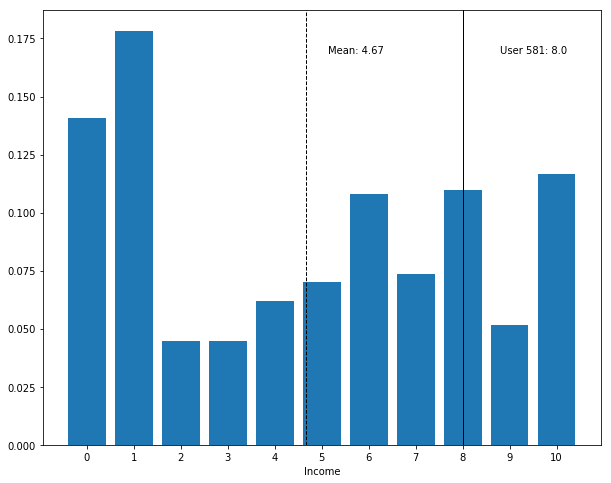

In [459]:
create_histogram(data, 'Income', column_mapping, prob=True, include_non_answers=True, show_mean=True, 
                     show_resp_row_num=581)

# Debugging code 